# Cardiac wall motion model

This notebook explores the sample data provided by The Cardiac Atlas Project website, in the hope of obtaining some information on the magnitude of heart wall motion during a cardiac cycle.

The data can be obtained from:
http://www.cardiacatlas.org/tools/biventricular-modes/

Atlas dataset of the first 200 PCA components of the heart shape from 630 healthy individuals.

The PCA structure is as follows:

/COEFF: N x 200 matrix of the first 200 principal components, where N is the number of  sample points, \
/LATENT: 200 elements vector of the eigenvalues,\
/EXPLAINED: 200 elements vector that show the percentage of the total variance explained by each principal component,\
/MU: N elements vector that defines the mean shape of the biventricular model.

In [1]:
%matplotlib inline
import numpy as np
import h5py
import matplotlib.pyplot as plt
import math
from mpl_toolkits import mplot3d
import plotly.graph_objects as go
import plotly.express as px
from mpl_toolkits.mplot3d import Axes3D
import pandas as pd

Open file in read mode:

In [2]:
hf = h5py.File('UKBRVLV.h5', 'r')

Get structure of datasets:

In [3]:
hf.keys()

<KeysViewHDF5 ['COEFF', 'EXPLAINED', 'LATENT', 'MU']>

Grab each dataset from hf:

In [4]:
coeff = hf.get('COEFF')
explained = hf.get('EXPLAINED')
latent = hf.get('LATENT')
mu = hf.get('MU')

Check data shape:

In [5]:
coeff.shape

(200, 34860)

In [6]:
len(coeff)

200

It seems that the object coeff has 200 items each with 34860 elements

In [7]:
explained.shape

(1, 200)

In [8]:
latent.shape

(1, 200)

In [9]:
mu.shape

(34860, 1)

Plot the first item in coeff

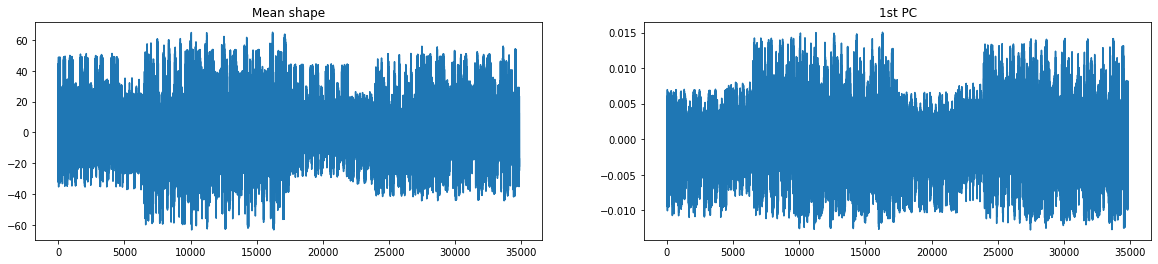

In [416]:
plt.figure(figsize=(20,4))

plt.subplot(121)
plt.plot(np.array(mu))
plt.title('Mean shape')

plt.subplot(122)
plt.plot(np.array(coeff[0]))
plt.title('1st PC')
plt.show()

This looks like time series data over two cardiac cycles. 

200


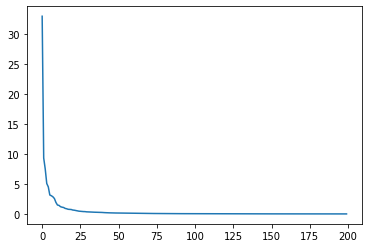

In [11]:
print(len(np.array(explained)[0]))
plt.plot(np.array(explained)[0])
plt.show()

Let's generate the first principal mode with 1.5 times the standard deviation

In [13]:
c = np.array(coeff)
l = np.array(latent)
m = np.array(mu)

Generate the first principal mode:

In [387]:
# Mean shape
M = np.transpose(mu)

# 'Mean+Std' shape
S = np.transpose(m) + (1.5 * np.sqrt(l[0,0]) * c[0,:])

# 'Mean-Std' shape
Sm =  np.transpose(m) - 1.5 * (np.sqrt(l[0,0]) * c[0,:])

S.shape==Sm.shape==M.shape

True

# Reshaping the vectors to extract ED and ES shapes
ED: end-diastolic shape

ES: end-sistoloc shape


In [399]:
N = S.shape[1] // 2
P = N/6

ed_p = np.reshape(S[0,:N], (-1,3))
es_p = np.reshape(S[0,N:], (-1,3))

ed_m = np.reshape(Sm[0,:N], (-1,3))
es_m = np.reshape(Sm[0,N:], (-1,3))

M_ed = np.reshape(M[0,:N], (-1,3))
M_es = np.reshape(M[0,N:], (-1,3))

In [384]:
def plot_shape(ed, es):
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    ax.scatter(ed[:,0], ed[:,1], ed[:,2], color='dodgerblue', marker='.')
    ax.scatter(es[:,0], es[:,1], es[:,2], color='firebrick', marker='.')

    # OR
    # ax.plot3D(ed[:,0], ed[:,1], ed[:,2], 'blue')

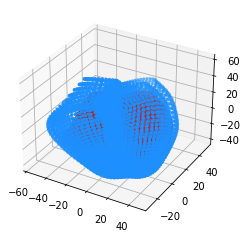

In [385]:
# Plotting Mean+Std shape at ED and ES phases
plot_shape(ed_p, es_p)

In [400]:
# Plotting Mean shape at ED and ES phases
plot_shape(M_ed, M_es)

In [390]:
# Plotting Mean-Std shape at ED and ES phases
plot_shape(ed_m, es_m)

Let's plot the element positions in the (x, y, z) directions at ED and ES to visualize the displacements

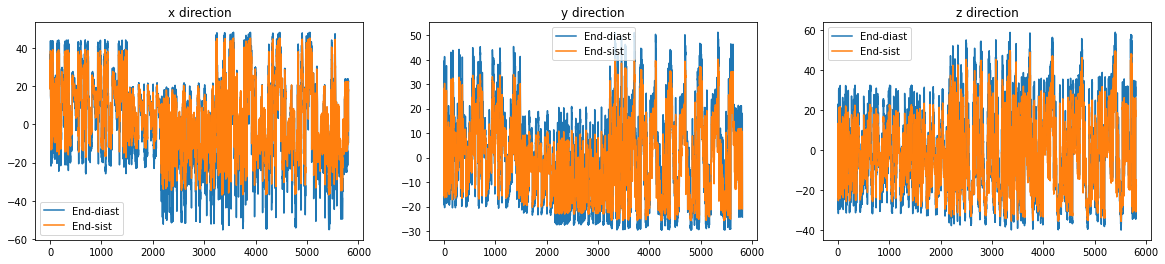

In [413]:
plt.figure(figsize=(20,4))
           
plt.subplot(1,3,1)
plt.plot(ed_p[:,0])
plt.plot(es_p[:,0])
plt.title('x direction')
plt.legend(('End-diast', 'End-sist'))

plt.subplot(1,3,2)
plt.plot(ed_p[:,1])
plt.plot(es_p[:,1])
plt.title('y direction')
plt.legend(('End-diast', 'End-sist'))

plt.subplot(1,3,3)
plt.plot(ed_p[:,2])
plt.plot(es_p[:,2])
plt.title('z direction')
plt.legend(('End-diast', 'End-sist'))
plt.show()

Now, let's plot the difference between ED and ES to obtained the displacements of the nodes.
At ED (end-diastole), the heart wall is at maximum relaxation, while at ES (end-systole) the wall is at maximum contraction. 
Thus, subtracting the shape vectors at ED and ES should give an estimation of the displacement of the heart wall during a cardiac cycle.

This can be done using either the mean shape (mu) or the mean+Std to incorporate the variability in the wall displacement. Let's plot them together to compare:

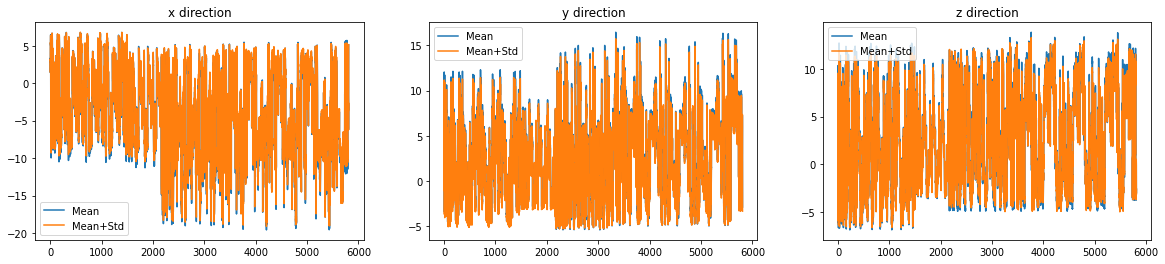

In [414]:
# Using the Mean shape
plt.figure(figsize=(20,4))

plt.subplot(131)
plt.plot(M_ed[:,0] - M_es[:,0])
plt.plot(ed_p[:,0] - es_p[:,0])
plt.title('x direction')
plt.legend(('Mean', 'Mean+Std'))

plt.subplot(132)
plt.plot(M_ed[:,1] - M_es[:,1])
plt.plot(ed_p[:,1] - es_p[:,1])
plt.title('y direction')
plt.legend(('Mean', 'Mean+Std'))

plt.subplot(133)
plt.plot(M_ed[:,2] - M_es[:,2])
plt.plot(ed_p[:,2] - es_p[:,2])
plt.title('z direction')
plt.legend(('Mean', 'Mean+Std'))
plt.show()

It seems that the variation is rather small and does not significantly alter the estimations.

Furthermore, it seems that the length of the heart (x-direction) actually decreases at ES since the difference is negative. 

The ED-ES difference in node positions in y- and z-directions in this template model seem to indicate a displacement in order of **15 mm** (I suppose that is the unit used, although this is not stated anywhere).

For an interactive view of the model, we can use the Scatter3d tool from Plotly. The downside is that it does not allow plotting muliple data.

In [392]:
fig = go.Figure(data=[go.Scatter3d(x=M_es[:,0], y=M_es[:,1], z=M_es[:,2],  mode='markers', marker=dict(size=6, colorscale='Viridis',   # choose a colorscale
       opacity=0.50))])
fig = go.Figure(data=[go.Scatter3d(x=M_ed[:,0], y=M_ed[:,1], z=M_ed[:,2],  mode='markers', marker=dict(size=6, colorscale='Viridis',   # choose a colorscale
       opacity=0.50))])
# or
#fig = go.Figure(data=[go.Mesh3d(x=es[:,0], y=es[:,1], z=es[:,2], color='lightpink', opacity=0.50)])
fig.show()

# Now let's inspect the MIDLIFE model

In [198]:
with open("SampleModel/MIDLIFE_01_1.model.exnode", "r") as file_object:
    data = file_object.read()
    print(data)

Region: /heart
#Fields=1
1) coordinates, coordinate, prolate spheroidal, focus= 38.1624, #Components=3
  lambda.  Value index= 1, #Derivatives= 3 (d/ds1,d/ds2,d2/ds1ds2)
  mu.  Value index= 5, #Derivatives= 0
  theta.  Value index= 6, #Derivatives= 0
Node:                            1
    8.0714300000000005e-01    2.8508728508700010e-01   -9.2469092468999481e-02    5.8659358659299965e-01
    2.2529400000000002e+00
    0.0000000000000000e+00
Node:                            2
    7.7254599999999995e-01    2.1307821307800001e-01   -8.8707088707000281e-02    3.5934335934300066e-01
    2.2302700000000000e+00
    1.5708000000000000e+00
Node:                            3
    7.8849400000000003e-01   -9.2658092658000513e-02    4.5153045153000004e-02    1.2014112014099965e-01
    2.2822600000000000e+00
    3.1415899999999999e+00
Node:                            4
    8.1719900000000001e-01   -2.2808722808700033e-01   -2.4300924300899984e-01   -2.9921429921400122e-01
    2.3082300000000000e+00


In [203]:
df.head(10)

Region: /heart
0                                          #Fields=1
1  1) coordinates, coordinate, prolate spheroidal...
2    lambda.  Value index= 1, #Derivatives= 3 (d/...
3               mu.  Value index= 5, #Derivatives= 0
4            theta.  Value index= 6, #Derivatives= 0
5                 Node:                            1
6      8.0714300000000005e-01    2.85087285087000...
7                             2.2529400000000002e+00
8                             0.0000000000000000e+00
9                 Node:                            2

In [206]:
df.loc[6][0]

'    8.0714300000000005e-01    2.8508728508700010e-01   -9.2469092468999481e-02    5.8659358659299965e-01'

In [259]:
df2 = df.drop(df.index[0:5][0])

In [242]:
df2.shape

(155, 1)

In [261]:
df2.loc[6][0]

'    8.0714300000000005e-01    2.8508728508700010e-01   -9.2469092468999481e-02    5.8659358659299965e-01'

Get points from all 28 files in SampleModel folder:

In [338]:
#def get_coord(string):
#    txt = string.split(" ")
#    for k in range(1, len(txt)):
#        if txt[k] != '':
#            coord = float(txt[k])
#            return coord
#            break

#df.columns = ['columns', 'lambda', 'mu', 'theta']

def get_pts(df, init_ind=0, interv=1):
    N = df.shape[0]
    pts = np.zeros((40,3))
    j=0
    for i in range(init_ind, N, interv):
        txt = df.loc[i][0].split(" ")
        for k in range(1, len(txt)):
            if txt[k] != '':
                coord = float(txt[k])
                break
                
        pts[j,0] = coord
        pts[j,1] = df.loc[i+1][0]
        pts[j,2] = df.loc[i+2][0]
        j += 1
    return pts

def get_pts2(df, init_ind=0, interv=1):
    N = df.shape[0]
    pts = np.zeros((40,3))
    j=0
    for i in range(init_ind, N, interv):
        txt = df.loc[i][0].split(" ")
        coord =np.zeros((3,1))
        l = 0
        for k in range(1, len(txt)):
            if txt[k] != '':
                if l < 3:
                    coord[l] = float(txt[k])
                    l += 1
                else:
                    break
                
        pts[j,0] = coord[0]
        pts[j,1] = coord[1]
        pts[j,2] = coord[2]
        j += 1
    return pts

Now let's check if the data extraction was successful by printing out the points.

In [417]:
print(pts)

[[0.807143 2.25294  0.      ]
 [0.772546 2.23027  1.5708  ]
 [0.788494 2.28226  3.14159 ]
 ...
 [1.00817  0.       1.5708  ]
 [1.00817  0.       3.14159 ]
 [1.00817  0.       4.71239 ]]


In [344]:
fig = go.Figure(data=[go.Scatter3d(x=pts[:,0], y=pts[:,1], z=pts[:,2],  mode='markers', opacity=0.50)])
#fig = go.Figure(data=[go.Mesh3d(x=pts[:,0], y=pts[:,1], z=pts[:,2], color='lightpink', opacity=0.50)])
fig.show()

I'm not sure what these data points are supposed to represent. It looks like it could be part of the heart wall, but can't really make anything useful out of it.

In [418]:
pts2 = np.zeros((40*28,3))
     
j=0
               
for i in range(1, 29):
    file  = f"SampleModel/MIDLIFE_01_{i}.model.exnode"
    df = pd.read_csv(file, sep =' ',  delimiter='\t')
    
    try:
        pts2[j:j+40,:] = get_pts2(df, init_ind=6, interv=4)
        j += 40
        print(f'Loaded file #{i}')
    except Exception:
        print('Could not get points')
        print(f'Stopped at file #{i}')
        raise
        break
       

Loaded file #1
Loaded file #2
Loaded file #3
Loaded file #4
Loaded file #5
Loaded file #6
Loaded file #7
Loaded file #8
Loaded file #9
Loaded file #10
Loaded file #11
Loaded file #12
Loaded file #13
Loaded file #14
Loaded file #15
Loaded file #16
Loaded file #17
Loaded file #18
Loaded file #19
Loaded file #20
Loaded file #21
Loaded file #22
Loaded file #23
Loaded file #24
Loaded file #25
Loaded file #26
Loaded file #27
Loaded file #28
